In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from scipy.special import (i1, i0, hyp1f1)
from scipy.optimize import brentq
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, evaluate_directions,
                       evaluate_metric, pca_noise_classifier,
                       pca_denoising)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [3]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [14]:
def _normalized_rician_expected_value(snr):
    """
    Computes the rician expected intensity normalized by the
    noise standard deviation given the signal ground truth.

    Parameters
    ----------
    signal : array
        Containing ground truth signal to convert to expected values
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esignal : array
       Rician expected values for the given ground truth signals
    """
    return np.sqrt(0.5*np.pi) * hyp1f1(-0.5, 1.0, -0.5*(snr)**2)

In [15]:
def _rician_error(snr, esnr):
    return esnr - _normalized_rician_expected_value(snr)

In [16]:
def rician_gt_value(esignal, sigma):
    """
    Computes the noise free intensity given the rician biases signal
    and the ground truth noise standard deviation.

    Parameters
    ----------
    esignal : array
        Containing rician biased signal
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esigma : array
       Ground truth bias free signal
    """
    esnrmin = _normalized_rician_expected_value(0)
    esnr = esignal * 1.0/ sigma
    if esnr < esnrmin:
        snr = 0
    else:
        snr = brentq(_rician_error, 0, esignal * 1.0/ sigma, args=(esignal * 1.0/ sigma))
    return snr * sigma

In [17]:
def rician_correction(dwi, sigma):
    """ Correct Rician bias of DWI volumes

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    sigma : float
        Estimate of the noise std

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the corrected 4D DWI data.
    """
    den = dwi.copy()
    for g in range(dwi.shape[3]):
        for k in range(dwi.shape[2]):
            for j in range(dwi.shape[1]):
                for i in range(dwi.shape[0]):
                    # Compute eigenvalues for sliding window
                    x = dwi[i, j, k, g]
                    den[i, j, k, g] =  rician_gt_value(x, sigma)
    return den

In [18]:
# initialize
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
dir1 = np.zeros(fsigmas.size)
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)

dir10 = np.zeros(dir1.shape)
dir20 = np.zeros(dir1.shape)
dir30 = np.zeros(dir1.shape)
fa10 = np.zeros(dir1.shape)
fa20 = np.zeros(dir1.shape)
fa30 = np.zeros(dir1.shape)
md10 = np.zeros(dir1.shape)
md20 = np.zeros(dir1.shape)
md30 = np.zeros(dir1.shape)
mk10 = np.zeros(dir1.shape)
mk20 = np.zeros(dir1.shape)
mk30 = np.zeros(dir1.shape)

fa_rician = np.zeros(dir1.shape)
md_rician = np.zeros(dir1.shape)
mk_rician = np.zeros(dir1.shape)

fa_gt = np.zeros(dir1.shape)
md_gt = np.zeros(dir1.shape)
mk_gt = np.zeros(dir1.shape)

snr = 15
sigma = 50.0 /snr

for p in range(4):
    # ground truth is now the average of rician noise data
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    dtiFgt0 = dtiM.fit(Phantom)
    FAgt0 = dtiFgt0.fa
    fa_gt[p] = np.mean(FAgt0[2:-2, 2:-2, 2:-2])
    MDgt0 = dtiFgt0.md
    md_gt[p] = np.mean(MDgt0[2:-2, 2:-2, 2:-2])
    directionsgt0 = dtiFgt0.directions
    dkiFgt0 = dkiM.fit(Phantom)
    MKgt0 = dkiFgt0.mk()
    mk_gt[p] = np.mean(MKgt0[2:-2, 2:-2, 2:-2])

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
    
    for rep in range(9):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_gt = Phantom_gt + _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt / 10
    
    dtiFgt1 = dtiM.fit(Phantom_gt)
    FAgt1 = dtiFgt1.fa
    fa_rician[p] = np.mean(FAgt1[2:-2, 2:-2, 2:-2])
    MDgt1 = dtiFgt1.md
    md_rician[p] = np.mean(MDgt1[2:-2, 2:-2, 2:-2])
    directionsgt1 = dtiFgt1.directions
    dkiFgt1 = dkiM.fit(Phantom_gt)
    MKgt1 = dkiFgt1.mk()
    mk_rician[p] = np.mean(MKgt1[2:-2, 2:-2, 2:-2])

    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

    # denoise and compare
    [Pden, sig, ncomps] = pca_denoising(Phantom_noise.copy(), ps=2, overcomplete=True)
    dtiF = dtiM.fit(Pden)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pden)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt1[2:-2, 2:-2, 2:-2])
    dir10[p] = p1
    dir20[p] = p2
    dir30[p] = p3
    zzz = np.zeros(FAgt1[2:-2, 2:-2, 2:-2].shape)
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], zzz)
    fa10[p] = p1
    fa20[p] = p2
    fa30[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], zzz)
    md10[p] = p1
    md20[p] = p2
    md30[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], zzz)
    mk10[p] = p1
    mk20[p] = p2
    mk30[p] = p3
    
    # rician correction and compare
    Pdenrician = rician_correction(Pden, sigma)
    dtiF = dtiM.fit(Pdenrician)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pdenrician)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt0[2:-2, 2:-2, 2:-2])
    dir1[p] = p1
    dir2[p] = p2
    dir3[p] = p3
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], zzz)
    fa1[p] = p1
    fa2[p] = p2
    fa3[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], zzz)
    md1[p] = p1
    md2[p] = p2
    md3[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], zzz)
    mk1[p] = p1
    mk2[p] = p2
    mk3[p] = p3

<Container object of 3 artists>

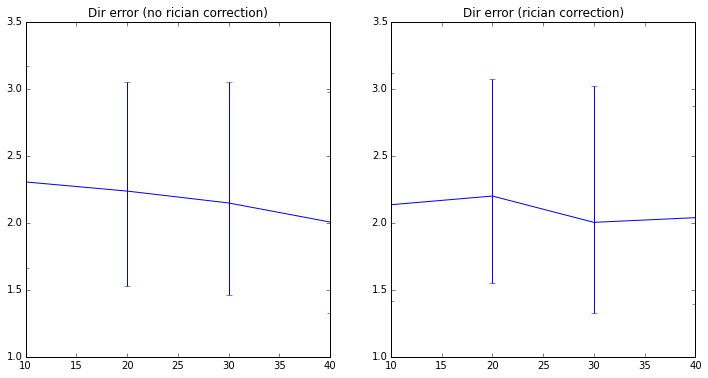

In [25]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('Dir error (no rician correction)')
ax.flat[0].errorbar(fsigmas, dir10, yerr=[dir20, dir30])
ax.flat[1].set_title('Dir error (rician correction)')
ax.flat[1].errorbar(fsigmas, dir1, yerr=[dir2, dir3])

(0, 50)

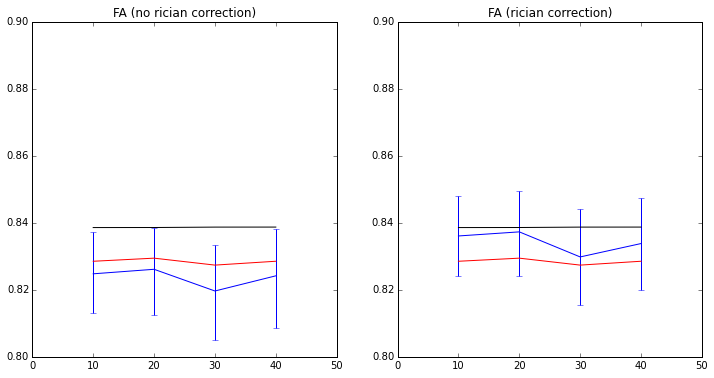

In [28]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('FA (no rician correction)')
ax.flat[0].plot(fsigmas, fa_gt, 'black')
ax.flat[0].plot(fsigmas, fa_rician, 'r')
ax.flat[0].errorbar(fsigmas, fa10, yerr=[fa20, fa30])
ax.flat[0].set_ylim([0.8, 0.9])
ax.flat[0].set_xlim([0, 50])
ax.flat[1].set_title('FA (rician correction)')
ax.flat[1].plot(fsigmas, fa_gt, 'black')
ax.flat[1].plot(fsigmas, fa_rician, 'r')
ax.flat[1].errorbar(fsigmas, fa1, yerr=[fa2, fa3])
ax.flat[1].set_ylim([0.8, 0.9])
ax.flat[1].set_xlim([0, 50])

(0, 50)

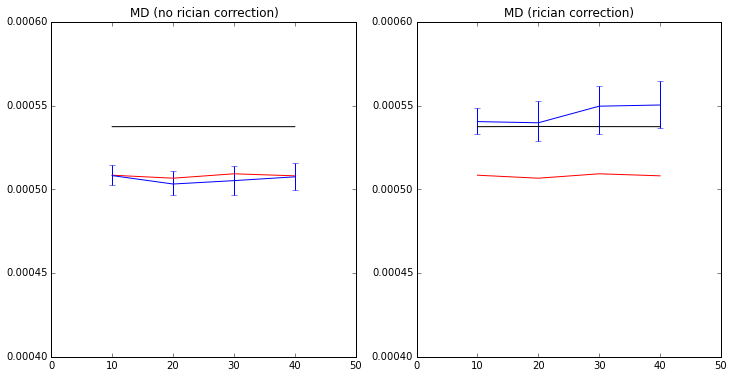

In [31]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('MD (no rician correction)')
ax.flat[0].plot(fsigmas, md_gt, 'black')
ax.flat[0].plot(fsigmas, md_rician, 'r')
ax.flat[0].errorbar(fsigmas, md10, yerr=[md20, md30])
ax.flat[0].set_ylim([0.4e-3, 0.6e-3])
ax.flat[0].set_xlim([0, 50])
ax.flat[1].set_title('MD (rician correction)')
ax.flat[1].plot(fsigmas, md_gt, 'black')
ax.flat[1].plot(fsigmas, md_rician, 'r')
ax.flat[1].errorbar(fsigmas, md1, yerr=[md2, md3])
ax.flat[1].set_ylim([0.4e-3, 0.6e-3])
ax.flat[1].set_xlim([0, 50])

(0, 50)

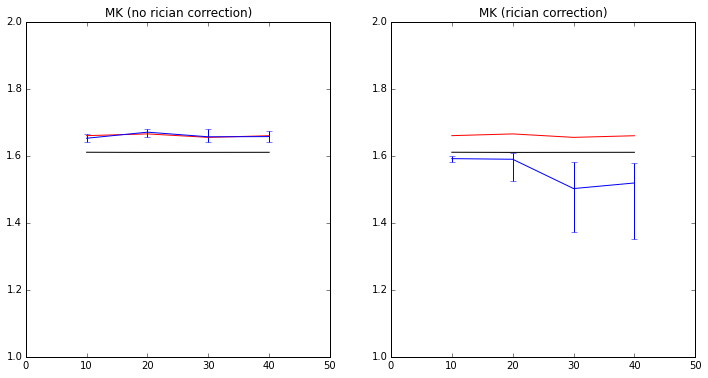

In [34]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('MK (no rician correction)')
ax.flat[0].plot(fsigmas, mk_gt, 'black')
ax.flat[0].plot(fsigmas, mk_rician, 'r')
ax.flat[0].errorbar(fsigmas, mk10, yerr=[mk20, mk30])
ax.flat[0].set_ylim([1, 2])
ax.flat[0].set_xlim([0, 50])

ax.flat[1].set_title('MK (rician correction)')
ax.flat[1].plot(fsigmas, mk_gt, 'black')
ax.flat[1].plot(fsigmas, mk_rician, 'r')
ax.flat[1].errorbar(fsigmas, mk1, yerr=[mk2, mk3])
ax.flat[1].set_ylim([1, 2])
ax.flat[1].set_xlim([0, 50])

In [35]:
def rician_correction(dwi, sigma):
    """ Correct Rician bias of DWI volumes

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    sigma : float
        Estimate of the noise std

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the corrected 4D DWI data.
    """
    den = dwi.copy()
    for g in range(dwi.shape[3]):
        for k in range(dwi.shape[2]):
            for j in range(dwi.shape[1]):
                for i in range(dwi.shape[0]):
                    # Compute eigenvalues for sliding window
                    x = dwi[i, j, k, g]
                    den[i, j, k, g] =  rician_gt_value(x, sigma[i, j, k])
    return den

In [36]:
# initialize
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
dir1 = np.zeros(fsigmas.size)
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)

dir10 = np.zeros(dir1.shape)
dir20 = np.zeros(dir1.shape)
dir30 = np.zeros(dir1.shape)
fa10 = np.zeros(dir1.shape)
fa20 = np.zeros(dir1.shape)
fa30 = np.zeros(dir1.shape)
md10 = np.zeros(dir1.shape)
md20 = np.zeros(dir1.shape)
md30 = np.zeros(dir1.shape)
mk10 = np.zeros(dir1.shape)
mk20 = np.zeros(dir1.shape)
mk30 = np.zeros(dir1.shape)

fa_rician = np.zeros(dir1.shape)
md_rician = np.zeros(dir1.shape)
mk_rician = np.zeros(dir1.shape)

fa_gt = np.zeros(dir1.shape)
md_gt = np.zeros(dir1.shape)
mk_gt = np.zeros(dir1.shape)

snr = 15
sigma = 50.0 /snr

for p in range(4):
    # ground truth is now the average of rician noise data
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    dtiFgt0 = dtiM.fit(Phantom)
    FAgt0 = dtiFgt0.fa
    fa_gt[p] = np.mean(FAgt0[2:-2, 2:-2, 2:-2])
    MDgt0 = dtiFgt0.md
    md_gt[p] = np.mean(MDgt0[2:-2, 2:-2, 2:-2])
    directionsgt0 = dtiFgt0.directions
    dkiFgt0 = dkiM.fit(Phantom)
    MKgt0 = dkiFgt0.mk()
    mk_gt[p] = np.mean(MKgt0[2:-2, 2:-2, 2:-2])

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
    
    for rep in range(9):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_gt = Phantom_gt + _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt / 10
    
    dtiFgt1 = dtiM.fit(Phantom_gt)
    FAgt1 = dtiFgt1.fa
    fa_rician[p] = np.mean(FAgt1[2:-2, 2:-2, 2:-2])
    MDgt1 = dtiFgt1.md
    md_rician[p] = np.mean(MDgt1[2:-2, 2:-2, 2:-2])
    directionsgt1 = dtiFgt1.directions
    dkiFgt1 = dkiM.fit(Phantom_gt)
    MKgt1 = dkiFgt1.mk()
    mk_rician[p] = np.mean(MKgt1[2:-2, 2:-2, 2:-2])

    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

    # denoise and compare
    [Pden, sig, ncomps] = pca_denoising(Phantom_noise.copy(), ps=2, overcomplete=True)
    dtiF = dtiM.fit(Pden)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pden)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt1[2:-2, 2:-2, 2:-2])
    dir10[p] = p1
    dir20[p] = p2
    dir30[p] = p3
    zzz = np.zeros(FAgt1[2:-2, 2:-2, 2:-2].shape)
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], zzz)
    fa10[p] = p1
    fa20[p] = p2
    fa30[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], zzz)
    md10[p] = p1
    md20[p] = p2
    md30[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], zzz)
    mk10[p] = p1
    mk20[p] = p2
    mk30[p] = p3
    
    # rician correction and compare
    Pdenrician = rician_correction(Pden, sig)
    dtiF = dtiM.fit(Pdenrician)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pdenrician)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt0[2:-2, 2:-2, 2:-2])
    dir1[p] = p1
    dir2[p] = p2
    dir3[p] = p3
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], zzz)
    fa1[p] = p1
    fa2[p] = p2
    fa3[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], zzz)
    md1[p] = p1
    md2[p] = p2
    md3[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], zzz)
    mk1[p] = p1
    mk2[p] = p2
    mk3[p] = p3

<Container object of 3 artists>

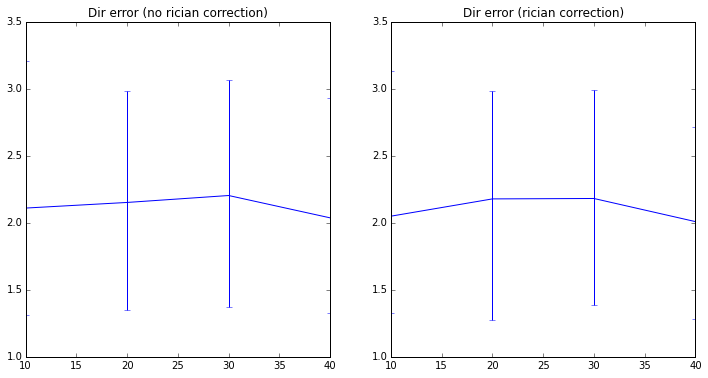

In [37]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('Dir error (no rician correction)')
ax.flat[0].errorbar(fsigmas, dir10, yerr=[dir20, dir30])
ax.flat[1].set_title('Dir error (rician correction)')
ax.flat[1].errorbar(fsigmas, dir1, yerr=[dir2, dir3])

(0, 50)

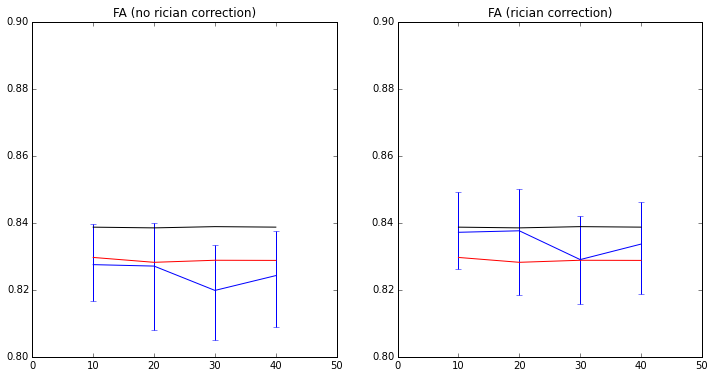

In [38]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('FA (no rician correction)')
ax.flat[0].plot(fsigmas, fa_gt, 'black')
ax.flat[0].plot(fsigmas, fa_rician, 'r')
ax.flat[0].errorbar(fsigmas, fa10, yerr=[fa20, fa30])
ax.flat[0].set_ylim([0.8, 0.9])
ax.flat[0].set_xlim([0, 50])
ax.flat[1].set_title('FA (rician correction)')
ax.flat[1].plot(fsigmas, fa_gt, 'black')
ax.flat[1].plot(fsigmas, fa_rician, 'r')
ax.flat[1].errorbar(fsigmas, fa1, yerr=[fa2, fa3])
ax.flat[1].set_ylim([0.8, 0.9])
ax.flat[1].set_xlim([0, 50])

(0, 50)

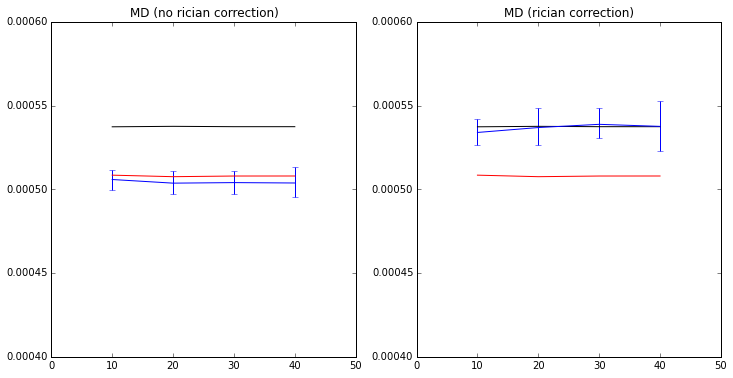

In [39]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('MD (no rician correction)')
ax.flat[0].plot(fsigmas, md_gt, 'black')
ax.flat[0].plot(fsigmas, md_rician, 'r')
ax.flat[0].errorbar(fsigmas, md10, yerr=[md20, md30])
ax.flat[0].set_ylim([0.4e-3, 0.6e-3])
ax.flat[0].set_xlim([0, 50])
ax.flat[1].set_title('MD (rician correction)')
ax.flat[1].plot(fsigmas, md_gt, 'black')
ax.flat[1].plot(fsigmas, md_rician, 'r')
ax.flat[1].errorbar(fsigmas, md1, yerr=[md2, md3])
ax.flat[1].set_ylim([0.4e-3, 0.6e-3])
ax.flat[1].set_xlim([0, 50])

(0, 50)

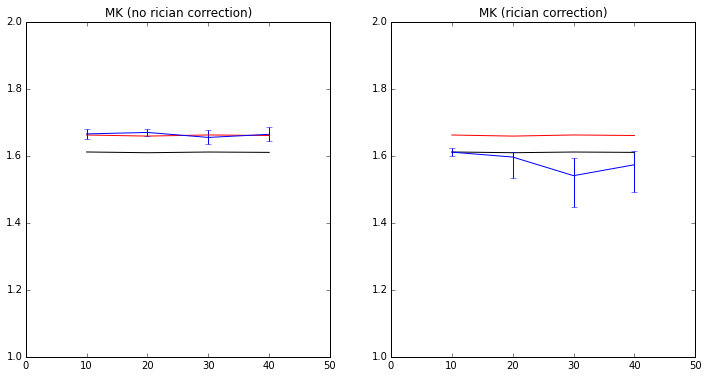

In [40]:
fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('MK (no rician correction)')
ax.flat[0].plot(fsigmas, mk_gt, 'black')
ax.flat[0].plot(fsigmas, mk_rician, 'r')
ax.flat[0].errorbar(fsigmas, mk10, yerr=[mk20, mk30])
ax.flat[0].set_ylim([1, 2])
ax.flat[0].set_xlim([0, 50])

ax.flat[1].set_title('MK (rician correction)')
ax.flat[1].plot(fsigmas, mk_gt, 'black')
ax.flat[1].plot(fsigmas, mk_rician, 'r')
ax.flat[1].errorbar(fsigmas, mk1, yerr=[mk2, mk3])
ax.flat[1].set_ylim([1, 2])
ax.flat[1].set_xlim([0, 50])